In [10]:
platform=input('Quale social vuoi utilizzare?')

!git clone https://github.com/jacoponudo/Size_effects.git
root='/kaggle/working/'
import sys
module_path = root+'Size_effects/EXP'
sys.path.append(module_path)
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from scipy import stats
import random
from scipy.stats import chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import pandas as pd
from EXP_package.functions import *
import tqdm 
!pip install fastparquet
!pip install gdown


if platform=='gab':
    # Scarica il dataset di Gab
    import gdown

    url='https://drive.google.com/uc?id=1CpsRAaBVv4hIoq713KQmWYyZOlMG2BpH'
    output='gab.parquet'

    gdown.download(url,output,quiet=False)
    gab = pd.read_parquet('/kaggle/working/gab.parquet')

    social=gab
    social['user_id']=social['user']
if platform=='reddit':
    # Scarica il dataset di Reddit
    import gdown

    url='https://drive.google.com/uc?id=1QepHehlhqP-jtOcshFzajqxj1DpJtoj7'
    output='reddit.parquet'

    gdown.download(url,output,quiet=False)
    reddit = pd.read_parquet('/kaggle/working/reddit.parquet')

    social=reddit
    social['created_at']=social['date']
if platform=='facebook':
    # Scarica i tre dataset che appartengono a Facebook
    import gdown
    url='https://drive.google.com/uc?id=1Y2lGWkcgo_IWHdWFh_Qcn0K74D_xQhvB'
    output='facebook_news.csv'
    gdown.download(url,output,quiet=False)

    url='https://drive.google.com/uc?id=1KGH2s8sPnvXZc7_wVgTCoGTXPr3B7SCe'
    output='facebook_brexit.csv'
    gdown.download(url,output,quiet=False)

    url='https://drive.google.com/uc?id=17q4X4JHYJBz1jF58XvYfbKqZLy-jtmzM'
    output='facebook_vaccines.csv'
    gdown.download(url,output,quiet=False)

    # Leggi i tre dataset con pandas
    facebook_news = pd.read_csv('/kaggle/working/facebook_news.csv', dtype={'from_id': str})
    facebook_vaccines_all_comments_scored = pd.read_csv('/kaggle/working/facebook_vaccines.csv', dtype={'from_id': str})
    facebook_brexit_all_comments_scored = pd.read_csv('/kaggle/working/facebook_brexit.csv', dtype={'from_id': str})

    # Etichetta e raggruppa i tre dataset
    facebook_vaccines = facebook_vaccines_all_comments_scored.copy()
    facebook_vaccines['topic'] = 'Vaccines'

    facebook_brexit= facebook_brexit_all_comments_scored.copy()
    facebook_brexit['topic'] = 'Brexit'

    facebook_news = facebook_news.copy()
    facebook_news['topic'] = 'News'

    facebook = pd.concat([facebook_vaccines, facebook_brexit, facebook_news])
    facebook.reset_index(drop=True, inplace=True)
    facebook['user_id']=facebook['from_id']

    social=facebook
    
sample = input('Vuoi prendere solo un campione di post?')
if sample.isdigit():
    sample = social['post_id'].sample(int(sample)) 
    social=social[social['post_id'].isin(sample)]

Quale social vuoi utilizzare? reddit


fatal: destination path 'Size_effects' already exists and is not an empty directory.


Downloading...
From (original): https://drive.google.com/uc?id=1QepHehlhqP-jtOcshFzajqxj1DpJtoj7
From (redirected): https://drive.google.com/uc?id=1QepHehlhqP-jtOcshFzajqxj1DpJtoj7&confirm=t&uuid=257758c4-1f26-42fc-b933-689fb77c13ce
To: /kaggle/working/reddit.parquet
100%|██████████| 334M/334M [00:03<00:00, 91.9MB/s] 


Vuoi prendere solo un campione di post? 20


# Gini index of Activity

Calcoliamo per ogni thread un coefficiente di Gini che misuri la concentrazione dell'attività degli utenti.

100%|██████████| 20/20 [00:00<00:00, 933.57it/s]


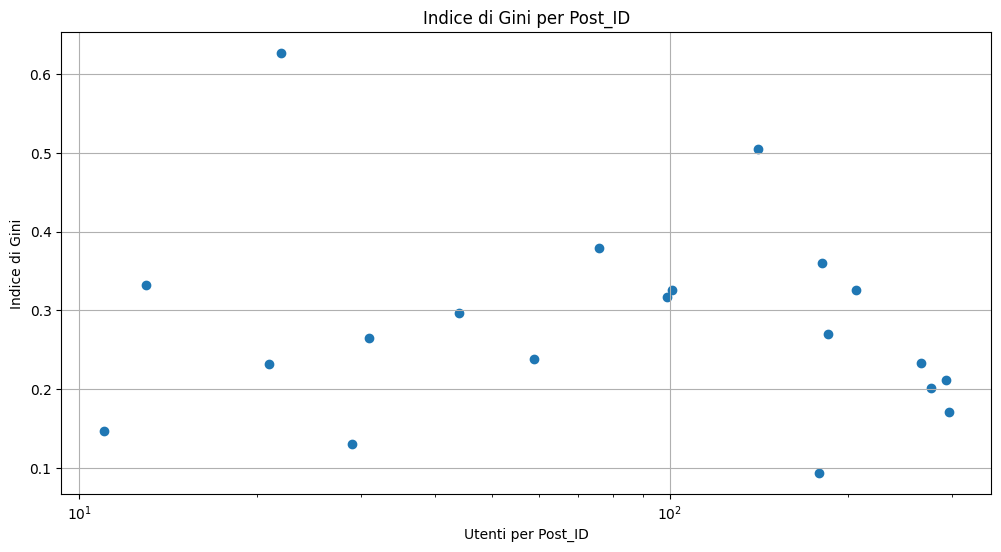

In [16]:
# Conta i commenti per ogni post_id
N_df = social.groupby('post_id')['user_id'].nunique().reset_index()
N_df.columns = ['post_id', 'count']
           #N_df=N_df[N_df['count']>50]

# Filtra i post con meno di 
so=social[social['post_id'].isin(N_df['post_id'])]

# Calcola il coefficiente di gini sulla concentrazione dell'attività degli utenti 
gini_df = calculate_gini_for_posts(so)

# Unisci i dati sul post_id
merged_df = pd.merge(gini_df, N_df, on='post_id')

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(merged_df['count'], merged_df['gini_index'])#, alpha=0.05)
plt.title('Indice di Gini per Post_ID')
plt.xlabel('Utenti per Post_ID')
plt.ylabel('Indice di Gini')
plt.xscale('log')  # Log scale for better visualization if the count ranges widely
plt.yscale('linear')  # Adjust scale as needed
plt.grid(True)
plt.show()


# Outreach della pagina 

Aggiungo la colonna con lo user_id dell'autore del post.

In [20]:
# Aggiungiamo la colonna autore, ovvero id della pagina che ha prodotto il post
social['created_at'] = pd.to_datetime(social['created_at'])
primi_mess = social.loc[social.groupby('post_id')['created_at'].idxmin()]
authors = primi_mess[['post_id', 'user_id']].rename(columns={'user_id': 'autore'})
social = social.merge(authors, on='post_id', suffixes=('', 'autore'))

# Aggiungo la data di creazionee di ogni post 
social.loc[:, 'created_at'] = pd.to_datetime(social['created_at'])
social['post_date'] = social.groupby('post_id')['created_at'].transform('min')

In [21]:
social

,id,comment_code,user_id,post_id,parent_id,link_id,subreddit_code,date,comment_text,toxicity_score,topic,created_at,autore,post_date,autoreautore,autoreautore
0,3649009.0,dxlkul6,t2_6l4z3,8dajxf,8dajxf,t3_8dajxf,t5_2qh4r,2018-04-19 00:22:06+00:00,[Archive.is link](https://archive.is/2020/http...,0.014200,conspiracy,2018-04-19 00:22:06+00:00,t2_6l4z3,2018-04-19 00:22:06+00:00,t2_6l4z3,t2_6l4z3
1,3649064.0,dxll6f4,t2_14y6o3,8dajxf,dxlkv11,t3_8dajxf,t5_2qh4r,2018-04-19 00:27:21+00:00,You know damn well she’s gonna be killed,0.785681,conspiracy,2018-04-19 00:27:21+00:00,t2_6l4z3,2018-04-19 00:22:06+00:00,t2_6l4z3,t2_6l4z3
2,3649002.0,dxlm0q5,t2_frlec,8dajxf,8dajxf,t3_8dajxf,t5_2qh4r,2018-04-19 00:41:26+00:00,Relevant Video- https://www.youtube.com/watch?...,0.026971,conspiracy,2018-04-19 00:41:26+00:00,t2_6l4z3,2018-04-19 00:22:06+00:00,t2_6l4z3,t2_6l4z3
3,3649058.0,dxlm59x,t2_11a7w1,8dajxf,8dajxf,t3_8dajxf,t5_2qh4r,2018-04-19 00:43:31+00:00,"'We'? Who do you think 'we' are, exactly?\n\n",0.013132,conspiracy,2018-04-19 00:43:31+00:00,t2_6l4z3,2018-04-19 00:22:06+00:00,t2_6l4z3,t2_6l4z3
4,3649019.0,dxlmate,t2_keje5,8dajxf,8dajxf,t3_8dajxf,t5_2qh4r,2018-04-19 00:46:03+00:00,[More info about the case](http://www.chicagot...,0.114297,conspiracy,2018-04-19 00:46:03+00:00,t2_6l4z3,2018-04-19 00:22:06+00:00,t2_6l4z3,t2_6l4z3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3911,1145299.0,hhwy8qc,t2_a0oab,qdxu4x,hhwxwbj,t3_qdxu4x,t5_mouw,2021-10-24 22:01:03+00:00,Prager from Prager University? I would like to...,0.156009,science,2021-10-24 22:01:03+00:00,t2_6l4z3,2021-10-23 04:32:12+00:00,t2_6l4z3,t2_6l4z3
3912,1145334.0,hhx4yfo,t2_afft1rm3,qdxu4x,hhro3k4,t3_qdxu4x,t5_mouw,2021-10-24 22:52:51+00:00,You are not going to lose that right. Itâs n...,0.149503,science,2021-10-24 22:52:51+00:00,t2_6l4z3,2021-10-23 04:32:12+00:00,t2_6l4z3,t2_6l4z3
3913,1145459.0,hi1jziv,t2_afft1rm3,qdxu4x,hhwy8qc,t3_qdxu4x,t5_mouw,2021-10-25 22:30:12+00:00,He had a radio show 20 years ago. I have no i...,0.026971,science,2021-10-25 22:30:12+00:00,t2_6l4z3,2021-10-23 04:32:12+00:00,t2_6l4z3,t2_6l4z3
3914,1144509.0,hlly1p4,t2_b8q1zbo,qdxu4x,hhtb2wl,t3_qdxu4x,t5_mouw,2021-11-22 06:07:21+00:00,That is so unfair to liberals though. Their id...,0.261044,science,2021-11-22 06:07:21+00:00,t2_6l4z3,2021-10-23 04:32:12+00:00,t2_6l4z3,t2_6l4z3


Parto da una lista di pagine, per ogniuna di queste calcolo per ogni post il numero di utenti coinvolti in generale dalla pagina in quel periodo

In [42]:
# Campiona 100 pagine
pages = social['autore'].unique()
outreach_results = []

for page in tqdm(pages):
    # Select all posts by the author (page)
    post_dates = social[social['autore'] == page][['autore', 'post_date', 'post_id']].drop_duplicates()

    # Count how many users commented on the post within the time window
    post_dates['users_one_month_window'] = post_dates.apply(lambda x: count_unique_users_within_period(x, 100), axis=1)

    # Append the results (including post_id) to the results list
    outreach_results.append(post_dates[['post_id', 'users_one_month_window']])


outreach_df = pd.concat(outreach_results, ignore_index=True)
outreach_df

100%|██████████| 14/14 [00:00<00:00, 80.16it/s]

2018-04-19 00:22:06+00:00
2018-06-01 23:10:46+00:00
2020-10-23 02:02:56+00:00
2021-05-14 01:00:23+00:00
2022-01-03 02:38:54+00:00
2021-03-28 20:38:19+00:00
2021-10-23 04:32:12+00:00
2018-09-01 07:00:54+00:00
2018-10-01 10:26:43+00:00
2019-01-02 04:42:33+00:00
2018-12-29 06:54:38+00:00
2018-11-17 23:33:39+00:00
2018-11-16 13:43:33+00:00
2018-11-04 21:39:18+00:00
2018-09-28 12:25:00+00:00
2018-08-05 19:10:15+00:00
2018-01-12 02:59:09+00:00
2018-01-22 00:11:50+00:00
2018-01-04 17:24:33+00:00
2019-02-11 01:10:16+00:00


Per ogni post calcola il coefficiente di concentrazione dell'attività (numero di commenti)

In [48]:
# Calcola il coefficiente di gini sulla concentrazione dell'attività degli utenti 
gini_df = calculate_gini_for_posts(social)
gini_df=gini_df.drop_duplicates()
gini_df

100%|██████████| 20/20 [00:00<00:00, 1122.34it/s]


,post_id,gini_index
0,7o4e5r,0.360099
1,7ptj8a,0.297033
2,7s1p3m,0.504508
3,8dajxf,0.264888
4,8nwckx,0.378823
5,94uabe,0.201814
6,9c14q3,0.332418
7,9jm7kf,0.233053
8,9kf588,0.626550
9,9u7cwx,0.212107


Join & Plot

In [51]:
outreach_df

,post_id,users_one_month_window
0,8dajxf,106
1,8nwckx,106
2,jgdt8i,59
3,nbwi1g,317
4,ruqrcf,277
5,mf9eh5,317
6,qdxu4x,277
7,9c14q3,13
8,9kf588,22
9,abpya0,101


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


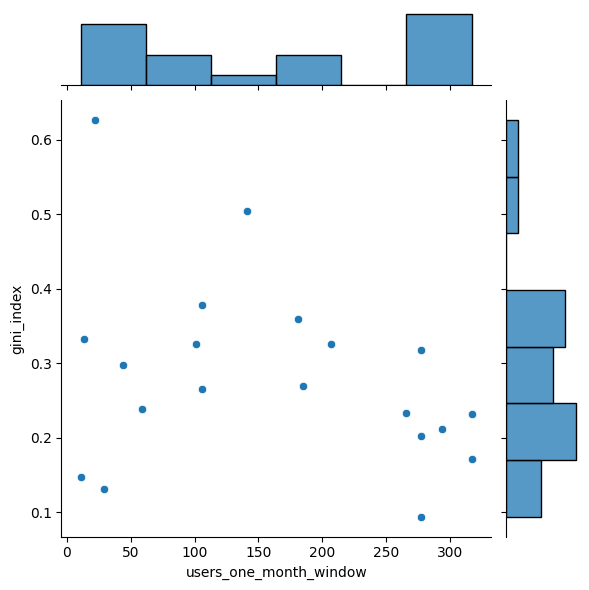

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Merging the two DataFrames on the 'Platform' column
merged_df = pd.merge(gini_df, outreach_df, on='post_id')

# Creating a joint plot of Gini Index vs Outreach Score
sns.jointplot(y='gini_index', x='users_one_month_window', data=merged_df, kind='scatter')

# Display the plot
plt.show()

## **Funcions** 

In [40]:
import pandas as pd
import numpy as np
from tqdm import tqdm
def gini_coefficient(values):
    if len(values) == 0:
        return np.nan  # O un valore che hai scelto per i casi senza dati
    sorted_values = np.sort(values)
    cumulative_values = np.cumsum(sorted_values)
    
    # Aggiungi un controllo per evitare problemi con array troppo piccoli
    if len(cumulative_values) == 1:
        return 0  # O un valore che hai scelto per i casi con un solo elemento
    
    lorenz_curve = cumulative_values / cumulative_values[-1]
    gini_index = 1 - 2 * np.trapz(lorenz_curve, dx=1/len(lorenz_curve))
    return gini_index


def calculate_gini_for_posts(df):
    """Calcola l'indice di concentrazione di Gini per ogni post_id basato sul numero di righe per utente."""
    gini_results = []
    
    # Raggruppa i dati per post_id
    grouped = df.groupby('post_id')
    
    for post_id, group in tqdm(grouped):
        # Conta il numero di righe per ogni utente
        user_counts = group['user_id'].value_counts()
        # Calcola l'indice di Gini per questi conteggi
        gini_index = gini_coefficient(user_counts.values)
        gini_results.append({'post_id': post_id, 'gini_index': gini_index})
    
    return pd.DataFrame(gini_results)

def count_unique_users_within_period(post_date, period):
    # Ensure 'post_date' is in datetime format
    post_date_value = pd.to_datetime(post_date['post_date'])
    
    # Define the time window around the post date
    start_time = post_date_value - pd.Timedelta(days=period)
    end_time = post_date_value + pd.Timedelta(days=period)

    # Filter comments within the time window and matching the author
    relevant_comments = social[(social['created_at'] >= start_time) & 
                               (social['created_at'] <= end_time) & 
                               (social['autore'] == post_date['autore'])]
    
    # Count unique users commenting within the time window
    unique_users = relevant_comments['user_id'].nunique()
    return unique_users
